In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
df = pd.read_csv("student/student-por.csv", sep=";")

y = df.pop("G3").values
X = df.copy()

X = pd.get_dummies(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [3]:
input_size = X_train.shape[1]
model = nn.Sequential(
    nn.Linear(input_size, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
).to(device)


In [4]:
n_epochs = 100
learning_rate = 0.001

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_history = []
test_loss_history = []

for epoch in range(n_epochs+1):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * features.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(epoch_loss)

    # Evaluate on test
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test.to(device))
        test_loss = loss_fn(test_outputs, y_test.to(device)).item()
        test_loss_history.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {epoch_loss:.4f}, Test Loss = {test_loss:.4f}")


Epoch 0: Train Loss = 148.5742, Test Loss = 125.0833
Epoch 10: Train Loss = 2.3382, Test Loss = 4.1129
Epoch 20: Train Loss = 1.1962, Test Loss = 3.6146
Epoch 30: Train Loss = 0.7172, Test Loss = 3.4648
Epoch 40: Train Loss = 0.4697, Test Loss = 3.4583
Epoch 50: Train Loss = 0.3066, Test Loss = 3.4837
Epoch 60: Train Loss = 0.2010, Test Loss = 3.5253
Epoch 70: Train Loss = 0.1366, Test Loss = 3.5149
Epoch 80: Train Loss = 0.0729, Test Loss = 3.5755
Epoch 90: Train Loss = 0.0356, Test Loss = 3.6003
Epoch 100: Train Loss = 0.0185, Test Loss = 3.6261


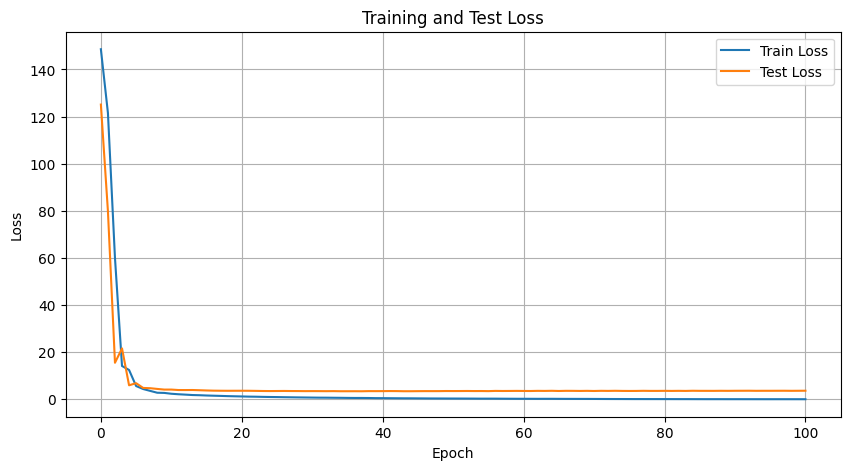

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Test Loss")
plt.grid()
plt.show()


In [6]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device)).cpu().numpy()
    y_true = y_test.numpy()

mae = mean_absolute_error(y_true, y_pred)

print(f"Средняя ошибка: {mae:.2f}")


Средняя ошибка: 1.31


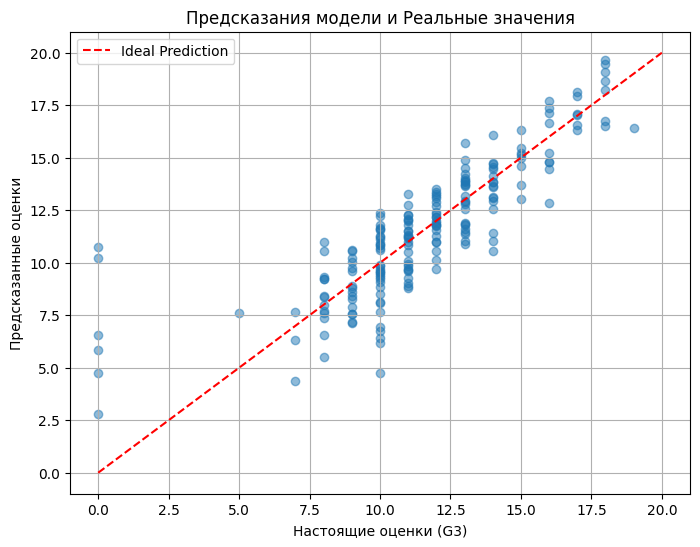

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 20], [0, 20], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel("Настоящие оценки (G3)")
plt.ylabel("Предсказанные оценки")
plt.title("Предсказания модели и Реальные значения")
plt.legend()
plt.grid()
plt.show()


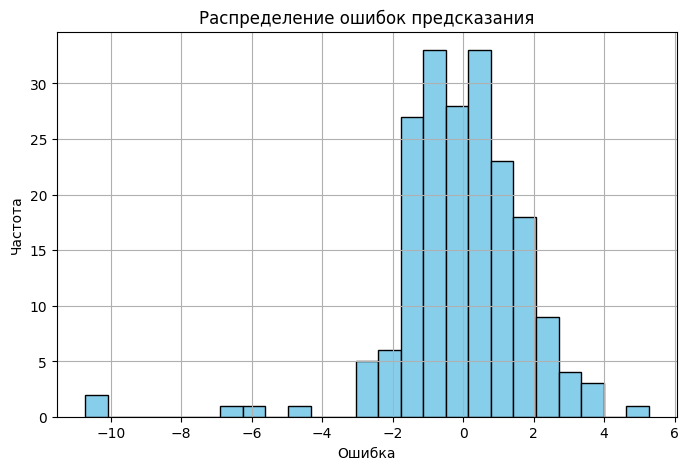

In [8]:
errors = y_true.flatten() - y_pred.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=25, color='skyblue', edgecolor='black')
plt.title("Распределение ошибок предсказания")
plt.xlabel("Ошибка")
plt.ylabel("Частота")
plt.grid()
plt.show()
